In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

2024-08-05 11:48:37.238540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 11:48:38.267016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# Define paths
base_dir = '/home/ubuntu/BSC/Breast_Cancer_Segmentation/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create ImageDataGenerators for augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32, class_mode=None)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(256, 256), batch_size=32, class_mode=None)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32, class_mode=None)

Found 1370 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 393 images belonging to 2 classes.


In [3]:
class AutoencoderDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_generator, batch_size):
        self.image_generator = image_generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        batch_x = self.image_generator[index]
        return batch_x, batch_x

# Create the custom data generators
train_autoencoder_generator = AutoencoderDataGenerator(train_generator, batch_size=32)
validation_autoencoder_generator = AutoencoderDataGenerator(validation_generator, batch_size=32)
test_autoencoder_generator = AutoencoderDataGenerator(test_generator, batch_size=32)

### Step 2: Define U-Net Model

In [4]:
# Define U-Net Model
def unet_autoencoder(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv10 = layers.Conv2D(3, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

autoencoder = unet_autoencoder()
autoencoder.summary()

2024-08-05 11:50:10.958264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-05 11:50:10.997841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-05 11:50:10.998111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [5]:
# Training the autoencoder
history = autoencoder.fit(train_autoencoder_generator, epochs=50, validation_data=validation_autoencoder_generator)


Epoch 1/50


2024-08-05 11:50:56.749731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-08-05 11:51:02.087124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2024-08-05 11:51:10.142372: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2669c7c6a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-05 11:51:10.142422: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-05 11:51:10.148641: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-05 11:51:10.316010

43/43 [==============================] - ETA: 0s - loss: 0.0166

2024-08-05 11:52:12.449388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 80s 1s/step - loss: 0.0166 - val_loss: 0.0102
Epoch 2/50
Epoch 2/50
43/43 [==============================] - 36s 830ms/step - loss: 5.1419e-04 - val_loss: 0.0102
Epoch 3/50
43/43 [==============================] - 35s 812ms/step - loss: 5.0625e-04 - val_loss: 0.0102
Epoch 4/50
43/43 [==============================] - 36s 814ms/step - loss: 5.4323e-04 - val_loss: 0.0102
Epoch 5/50
43/43 [==============================] - 36s 835ms/step - loss: 5.5251e-04 - val_loss: 0.0102
Epoch 6/50
43/43 [==============================] - 36s 823ms/step - loss: 6.0530e-04 - val_loss: 0.0102
Epoch 7/50
43/43 [==============================] - 36s 827ms/step - loss: 5.1202e-04 - val_loss: 0.0102
Epoch 8/50
43/43 [==============================] - 37s 839ms/step - loss: 5.4041e-04 - val_loss: 0.0102
Epoch 9/50
43/43 [==============================] - 36s 825ms/step - loss: 4.5137e-04 - val_loss: 0.0102
Epoch 10/50
43/43 [==============================] - 36s 816ms

In [6]:
# Save the trained model
autoencoder.save('breast_cancer_autoencoder.h5')

In [7]:
# Evaluate on the test set
test_loss = autoencoder.evaluate(test_autoencoder_generator)
print(f"Test Loss: {test_loss}")

2024-08-05 12:24:16.313944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 6s 502ms/step - loss: 0.0046
Test Loss: 0.0046104006469249725


#### Visualizing the Performance
To visualize the performance, you can plot the training and validation loss over epochs

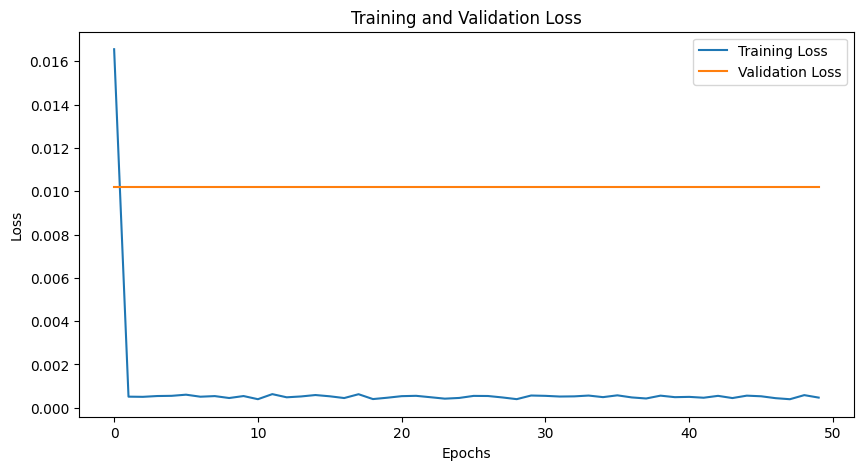

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


The plot of the training and validation loss shows a few key points:

- Training Loss: The training loss rapidly decreases and flattens out near zero, indicating that the model is learning to reconstruct the training images very well.
- Validation Loss: The validation loss, on the other hand, remains almost constant and higher than the training loss, indicating that the model is not generalizing well to unseen data (overfitting).

### Visualizing the Predictions
To visualize the predictions, you can select some images from the test set, run them through the autoencoder, and plot the original and reconstructed images side by side.

1/1 [==============================] - 0s 334ms/step


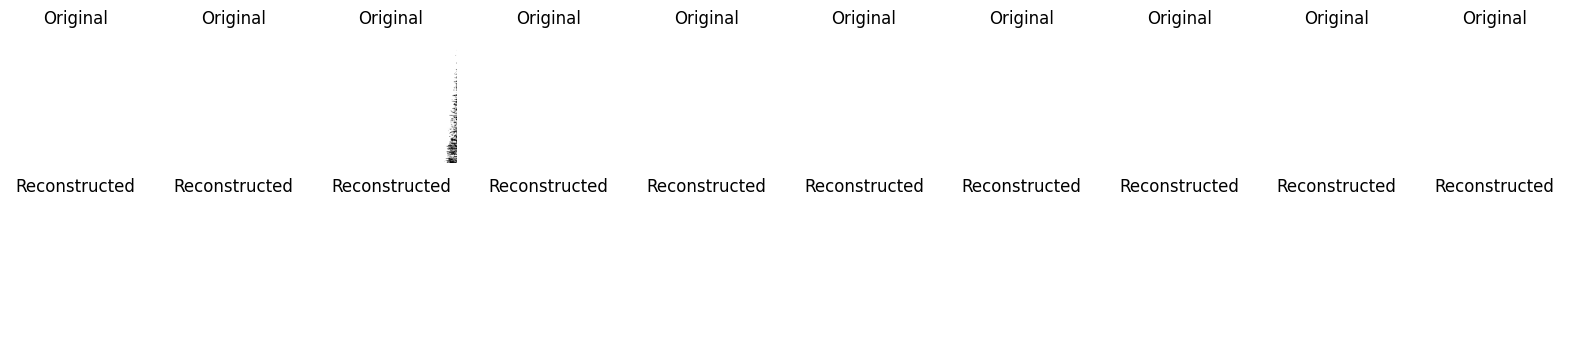

In [9]:
def plot_reconstructed_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Get a batch of images from the test set
test_images = next(iter(test_autoencoder_generator))[0]
# Get the reconstructed images
reconstructed_images = autoencoder.predict(test_images)

# Plot original and reconstructed images
plot_reconstructed_images(test_images, reconstructed_images, n=10)
